# **IMPORT IMPORTANT LIBRARIES**



In [141]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import itertools
import cv2 as cv
import PIL
import PIL.Image

from PIL import Image
from collections import Counter
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from shutil import copyfile
from sklearn.model_selection import train_test_split
# from google.colab import files


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# **SET HYPERPARAMETER**

In [2]:
BATCH_SIZE = 50
IMG_HEIGHT = 299
IMG_WIDTH = 299
EPOCHS = 100

# **DATA PIPELINING**

# **Extract**

In [93]:
# Mengunduh dataset dari GitHub dengan git clone
# !git clone https://github.com/zidan2808/NEW-ART-DATASETS.git

# Mengatur path ke folder dataset
dataset_dir = 'NEW ART DATASETS/ARTSCAPE'

# Buat direktori baru untuk menyimpan gambar yang telah diproses
preprocessed_dir = 'preprocessed_art'
if not os.path.exists(preprocessed_dir):
    os.makedirs(preprocessed_dir)

In [94]:
# Fungsi untuk mendapatkan daftar kelas dan jumlah masing-masing kelas
def get_class_distribution(dataset_dir):
    class_counts = Counter()

    # Loop melalui subdirektori dalam dataset_dir
    for root, dirs, files in os.walk(dataset_dir):
        for dir_name in dirs:
            class_dir = os.path.join(root, dir_name)
            num_images = len([f for f in os.listdir(class_dir)
                             if os.path.isfile(os.path.join(class_dir, f))])
            # Nama kelas diambil dari nama subdirektori terakhir
            class_name = os.path.basename(class_dir)
            class_counts[class_name] += num_images

    return class_counts


# Mendapatkan jumlah masing-masing kelas
class_counts = get_class_distribution(dataset_dir)

# Menghitung total jumlah kelas dan total jumlah file
num_classes = len(class_counts)
total_file_count = sum(class_counts.values())

# Membuat DataFrame dari hasil penghitungan
class_counts_df = pd.DataFrame.from_dict(
    class_counts, orient='index', columns=['Jumlah'])
class_counts_df.index.name = 'Genre'
class_counts_df.reset_index(inplace=True)

# Menampilkan tabel
print(class_counts_df)

# Menampilkan total jumlah kelas dan total jumlah file
print(f"\nTotal Jenis Genre Seni: {num_classes}")
print(f"Total Jumlah FIle: {total_file_count}")

           Genre  Jumlah
0       Abstract     500
1         Cubism     500
2        Dadaism     500
3        Fauvism     500
4  Impressionism     500
5        Nouveau     500
6            Pop     500
7        Realism     500
8    Renaissance     500
9     Surrealism     500

Total Jenis Genre Seni: 10
Total Jumlah FIle: 5000


In [95]:
# Fungsi untuk mendapatkan daftar kelas dan jumlah masing-masing kelas
def get_class_distribution(dataset_dir):
    class_counts = Counter()
    extension_counts = Counter()

    # Loop melalui subdirektori dalam dataset_dir
    for root, dirs, files in os.walk(dataset_dir):
        for dir_name in dirs:
            class_dir = os.path.join(root, dir_name)
            num_images = len([f for f in os.listdir(class_dir)
                             if os.path.isfile(os.path.join(class_dir, f))])
            # Nama kelas diambil dari nama subdirektori terakhir
            class_name = os.path.basename(class_dir)
            class_counts[class_name] += num_images

            # Menghitung jumlah file berdasarkan ekstensi
            for file in os.listdir(class_dir):
                if os.path.isfile(os.path.join(class_dir, file)):
                    file_extension = os.path.splitext(file)[1].lower()
                    extension_counts[file_extension] += 1

    return class_counts, extension_counts


# Mendapatkan jumlah masing-masing kelas dan ekstensi file
class_counts, extension_counts = get_class_distribution(dataset_dir)

# Membuat DataFrame dari hasil penghitungan ekstensi
extension_counts_df = pd.DataFrame.from_dict(
    extension_counts, orient='index', columns=['Jumlah'])
extension_counts_df.index.name = 'Ekstensi'
extension_counts_df.reset_index(inplace=True)

# Menampilkan tabel
print(extension_counts_df)

  Ekstensi  Jumlah
0     .jpg    4681
1     .png     312
2     .ini       1
3     .gif       5
4    .jpeg       1


# **Transform**

In [6]:
# def preprocess_and_save_image(image_path, save_path):
#     try:
#         with Image.open(image_path) as img:
#             # Jika gambar dalam mode CMYK, konversi ke RGB
#             if img.mode == 'CMYK':
#                 img = img.convert('RGB')

#             # Mengubah ukuran gambar
#             img = img.resize((IMG_HEIGHT, IMG_WIDTH))

#             # Menyimpan gambar sebagai PNG
#             img.save(save_path, 'PNG')
#     except OSError as e:
#         print(f"Error processing image {image_path}: {e}")


# # Menelusuri direktori dataset dan memproses gambar
# for root, dirs, files in os.walk(dataset_dir):
#     for file in files:
#         if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', '.tiff', '.gif')):
#             image_path = os.path.join(root, file)
#             relative_path = os.path.relpath(image_path, dataset_dir)
#             save_path = os.path.join(
#                 preprocessed_dir, os.path.splitext(relative_path)[0] + '.png')

#             # Membuat direktori jika belum ada
#             os.makedirs(os.path.dirname(save_path), exist_ok=True)

#             # Memproses dan menyimpan gambar
#             preprocess_and_save_image(image_path, save_path)

# print("Semua gambar telah diproses dan disimpan sebagai PNG.")

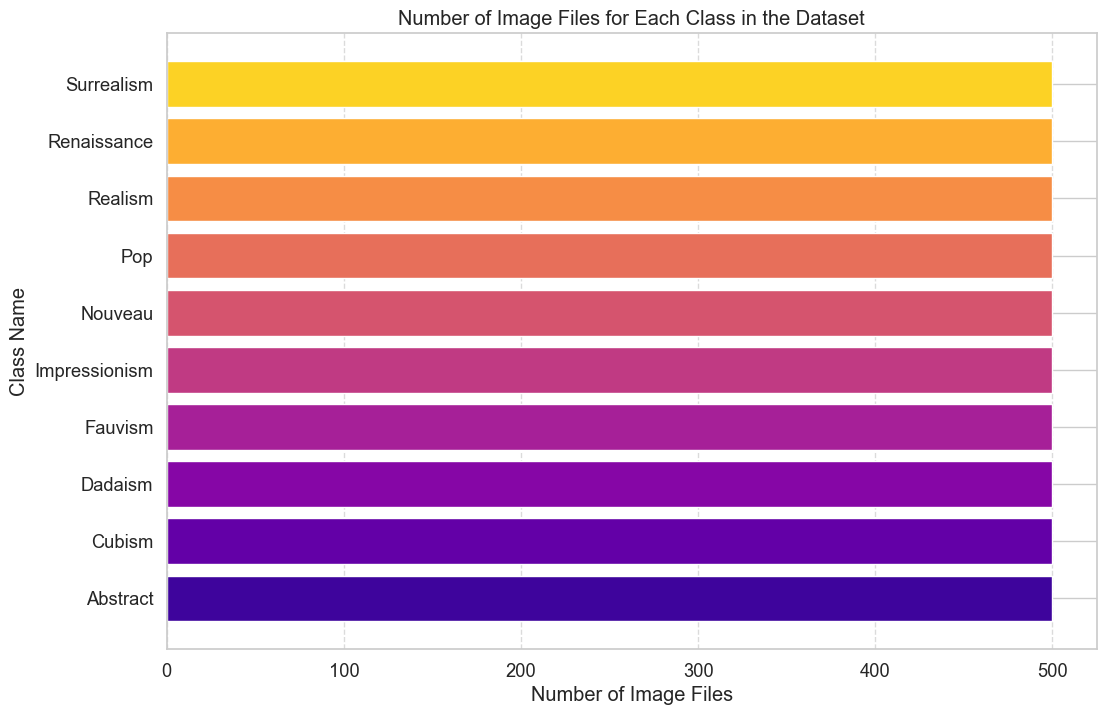

In [142]:
# Mengurutkan kelas berdasarkan jumlah file
sorted_class_counts = sorted(
    class_counts.items(), key=lambda x: x[1], reverse=False)
sorted_class_names = [item[0] for item in sorted_class_counts]
sorted_file_counts = [item[1] for item in sorted_class_counts]

# Setel palet warna berdasarkan jumlah kelas
palette = sns.color_palette("plasma", len(sorted_class_counts))

# Membuat plot
plt.figure(figsize=(12, 8))
plt.barh(sorted_class_names, sorted_file_counts, color=palette)
plt.xlabel('Number of Image Files')
plt.ylabel('Class Name')
plt.title('Number of Image Files for Each Class in the Dataset')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Menampilkan plot
plt.show()

# **Load**

In [8]:
# # Path ke direktori dataset asli
# original_dataset_dir = 'preprocessed_art'

# # Path ke direktori baru untuk dataset yang sudah dipisah
# base_dir = 'new_dir'
# os.makedirs(base_dir, exist_ok=True)

# # Membuat sub-direktori untuk data training dan validasi
# train_dir = os.path.join(base_dir, 'train')
# os.makedirs(train_dir, exist_ok=True)
# validation_dir = os.path.join(base_dir, 'validation')
# os.makedirs(validation_dir, exist_ok=True)

# # Daftar nama kelas (nama direktori di dalam original_dataset_dir)
# class_names = os.listdir(original_dataset_dir)

# # Memisahkan data menjadi bagian training dan validation
# for class_name in class_names:
#     # Path ke direktori kelas di dataset asli
#     class_original_dir = os.path.join(original_dataset_dir, class_name)

#     # Path ke direktori kelas di dataset baru untuk training dan validasi
#     class_train_dir = os.path.join(train_dir, class_name)
#     os.makedirs(class_train_dir, exist_ok=True)
#     class_validation_dir = os.path.join(validation_dir, class_name)
#     os.makedirs(class_validation_dir, exist_ok=True)

#     # Memisahkan path gambar menjadi bagian training dan validasi
#     image_paths = [os.path.join(class_original_dir, image_name)
#                    for image_name in os.listdir(class_original_dir)]
#     train_image_paths, validation_image_paths = train_test_split(
#         image_paths, test_size=0.2, random_state=42)

#     # Menyalin gambar ke direktori training
#     for image_path in train_image_paths:
#         image_name = os.path.basename(image_path)
#         target_path = os.path.join(class_train_dir, image_name)
#         copyfile(image_path, target_path)

#     # Menyalin gambar ke direktori validation
#     for image_path in validation_image_paths:
#         image_name = os.path.basename(image_path)
#         target_path = os.path.join(class_validation_dir, image_name)
#         copyfile(image_path, target_path)

# print("Pemisahan dataset selesai.")

In [97]:
# Path ke direktori train dan validasi
train_dir = 'new_dir/train'
validation_dir = 'new_dir/validation'

# Fungsi untuk menghitung jumlah file dalam direktori


def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))


# Menghitung jumlah file dalam direktori train dan validasi
num_train_files = count_files_in_directory(train_dir)
num_validation_files = count_files_in_directory(validation_dir)

print(f"Jumlah file dalam direktori train: {num_train_files}")
print(f"Jumlah file dalam direktori validation: {num_validation_files}")

Jumlah file dalam direktori train: 3999
Jumlah file dalam direktori validation: 1000


In [98]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.2],
    channel_shift_range=0.1,
    fill_mode='nearest'
)

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_dataset = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 3999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [99]:
class_indices = train_dataset.class_indices
num_classes = len(class_indices)
print(f"Jumlah kelas: {num_classes}")
print("Label kelas:", class_indices)

Jumlah kelas: 10
Label kelas: {'Abstract': 0, 'Cubism': 1, 'Dadaism': 2, 'Fauvism': 3, 'Impressionism': 4, 'Nouveau': 5, 'Pop': 6, 'Realism': 7, 'Renaissance': 8, 'Surrealism': 9}


In [100]:
class_indices = validation_dataset.class_indices
num_classes = len(class_indices)
print(f"Jumlah kelas: {num_classes}")
print("Label kelas:", class_indices)

Jumlah kelas: 10
Label kelas: {'Abstract': 0, 'Cubism': 1, 'Dadaism': 2, 'Fauvism': 3, 'Impressionism': 4, 'Nouveau': 5, 'Pop': 6, 'Realism': 7, 'Renaissance': 8, 'Surrealism': 9}


In [145]:
# Menampilkan beberapa contoh gambar
def plot_images(images_arr, labels_arr, class_indices, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        label = list(class_indices.keys())[
            list(class_indices.values()).index(np.argmax(lbl))]
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

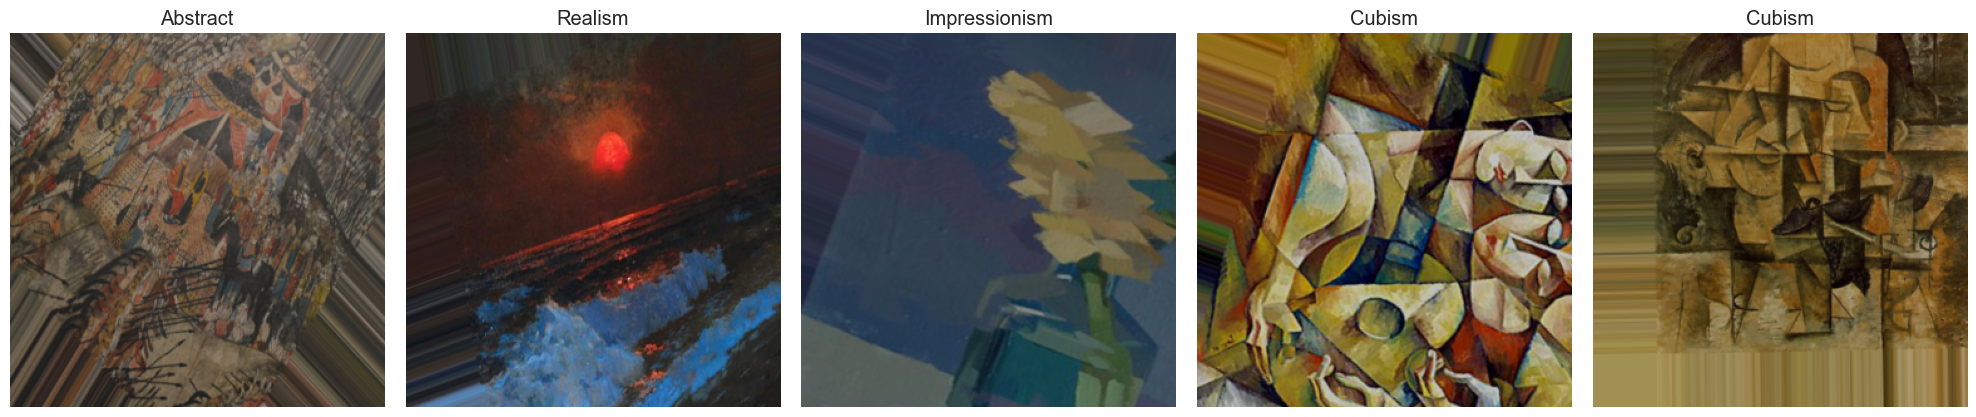

In [146]:
# Mendapatkan batch gambar dan label
images, labels = next(train_dataset)

# Menampilkan 5 contoh gambar
plot_images(images[:5], labels[:5], class_indices, num_images=5)

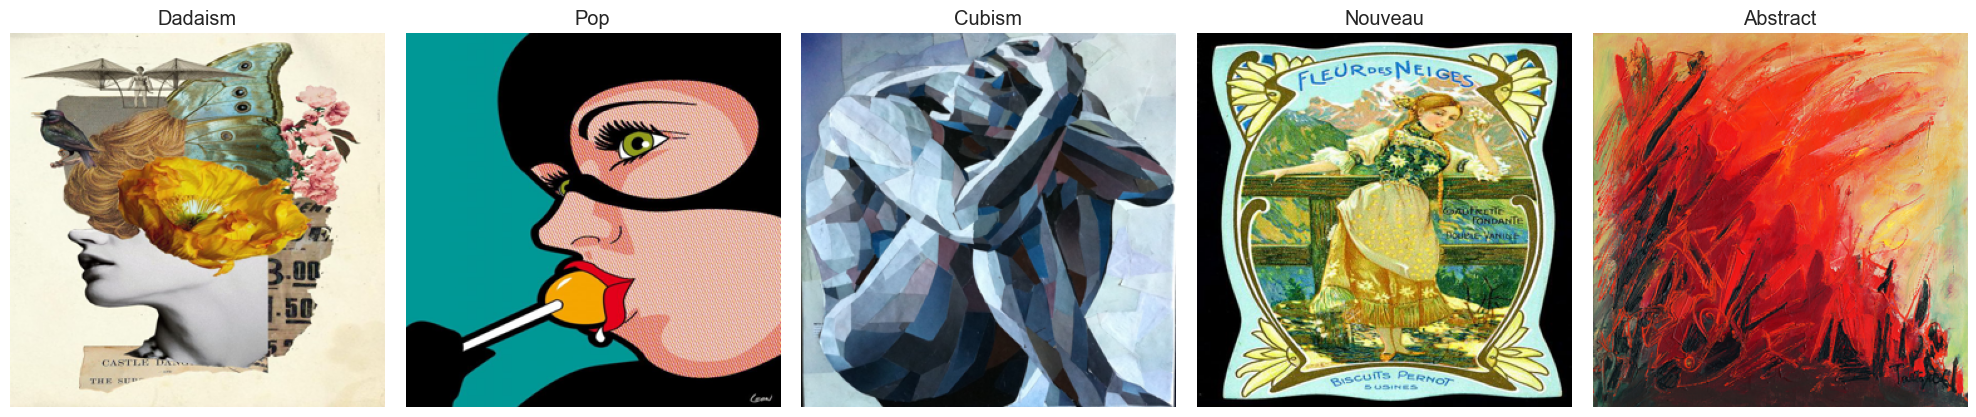

In [143]:
# Mendapatkan batch gambar dan label
images, labels = next(validation_dataset)

# Menampilkan 5 contoh gambar
plot_images(images[:5], labels[:5], class_indices, num_images=5)

#### Imagenet Exception

In [103]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3),
    pooling='avg'
)

for layer in base_model.layers:
    layer.trainable = False

model = base_model.output
model = Dense(128, activation='relu')(model)
model = Dropout(.5)(model)
model = Dense(256, activation='relu')(model)
model = Dropout(.5)(model)
model = Dense(512, activation='relu')(model)
model = Dropout(.5)(model)
output_layer = Dense(num_classes, activation='softmax')(model)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

In [16]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [104]:
# Buat model checkpoint
checkpoint = ModelCheckpoint(
    'best_model.h5',              # Nama file untuk menyimpan model
    monitor='val_accuracy',       # Metrik yang dipantau
    # Verbosity mode, 1 = menampilkan pesan saat checkpoint disimpan
    verbose=1,
    save_best_only=True,          # Hanya menyimpan model terbaik
    mode='max',                   # Mode untuk metrik yang dipantau, 'max' untuk akurasi
    # Menyimpan seluruh model (False) atau hanya bobot (True)
    save_weights_only=False,
    # Frekuensi penyimpanan checkpoint, 'epoch' untuk setiap akhir epoch
    save_freq='epoch'
)

In [18]:
# Train the model with checkpoint callback
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint],  
    verbose=1
)

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 2.2983 - accuracy: 0.1278
Epoch 1: val_accuracy improved from -inf to 0.29900, saving model to best_model.h5
80/80 [==============================] - 103s 1s/step - loss: 2.2983 - accuracy: 0.1278 - val_loss: 2.2393 - val_accuracy: 0.2990
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 2.2296 - accuracy: 0.1743
Epoch 2: val_accuracy improved from 0.29900 to 0.38300, saving model to best_model.h5
80/80 [==============================] - 85s 1s/step - loss: 2.2296 - accuracy: 0.1743 - val_loss: 2.1267 - val_accuracy: 0.3830
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 2.0976 - accuracy: 0.2448
Epoch 3: val_accuracy improved from 0.38300 to 0.43200, saving model to best_model.h5
80/80 [==============================] - 81s 1s/step - loss: 2.0976 - accuracy: 0.2448 - val_loss: 1.9390 - val_accuracy: 0.4320
Epoch 4/100
80/80 [==============================] - ETA: 0s - loss: 1.9

In [105]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

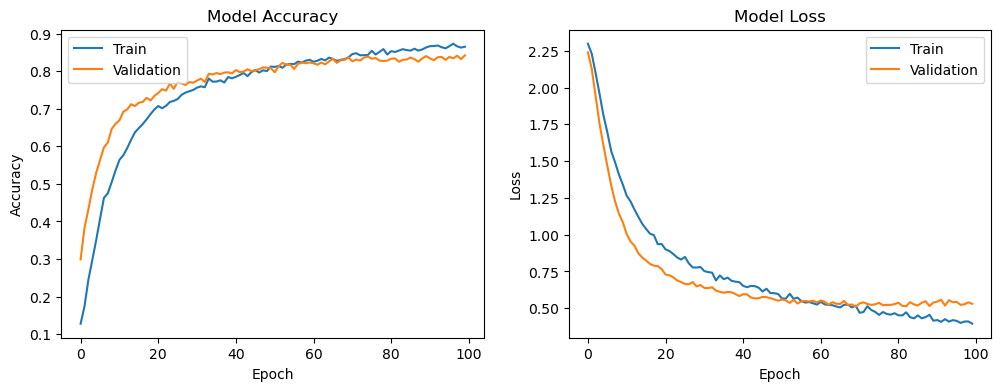

In [107]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [21]:
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

20/20 [==============================] - 8s 398ms/step - loss: 0.5297 - accuracy: 0.8420
Validation Loss: 0.5297
Validation Accuracy: 0.8420


In [34]:
# Save the model to a .h5 file
model.save('genre_classification_84.h5')

In [59]:
# Simpan model ke format .keras
model.save('genre_classification_84.keras', save_format='keras')

In [70]:
for class_name in train_dataset.class_indices:
    print(class_name)

Abstract
Cubism
Dadaism
Fauvism
Impressionism
Nouveau
Pop
Realism
Renaissance
Surrealism


In [71]:
id2label = dict((v, k) for k, v in train_dataset.class_indices.items())
id2label

{0: 'Abstract',
 1: 'Cubism',
 2: 'Dadaism',
 3: 'Fauvism',
 4: 'Impressionism',
 5: 'Nouveau',
 6: 'Pop',
 7: 'Realism',
 8: 'Renaissance',
 9: 'Surrealism'}

In [115]:
model = tf.keras.models.load_model('genre_classification_84.keras')

In [116]:
y_actual = []
y_pred = []

for class_name in train_dataset.class_indices:
    path_folder = os.path.join(validation_dir, class_name)

    for filename in os.listdir(path_folder):
        file_ = os.path.join(path_folder, filename)
        img = cv.imread(file_)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (299, 299))
        prediction = model.predict(np.array([img])/255)
        index = np.argmax(prediction)

        y_actual.append(class_name)
        y_pred.append(id2label[index])

print(y_actual)
print(y_pred)

1/1 [==============================] - 0s 23ms/step
['Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract', 'Abstract',

In [117]:
print(classification_report(y_actual, y_pred))

               precision    recall  f1-score   support

     Abstract       0.86      0.67      0.75       100
       Cubism       0.88      0.93      0.90       100
      Dadaism       0.89      0.99      0.94       100
      Fauvism       0.82      0.89      0.85       100
Impressionism       0.68      0.72      0.70       100
      Nouveau       0.91      0.98      0.94       100
          Pop       0.94      0.89      0.91       100
      Realism       0.79      0.61      0.69       100
  Renaissance       0.82      0.88      0.85       100
   Surrealism       0.83      0.86      0.85       100

     accuracy                           0.84      1000
    macro avg       0.84      0.84      0.84      1000
 weighted avg       0.84      0.84      0.84      1000



In [131]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap='terrain_r'):
    if normalize:
        cm = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    else:
        print("Confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = ".2f" if normalize else 'd'
    thresh = cm.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center',
                 fontsize=12, weight='bold', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.xlabel('Predicted label', fontsize=16)

In [132]:
classes = [class_name for class_name in train_dataset.class_indices]
classes

['Abstract',
 'Cubism',
 'Dadaism',
 'Fauvism',
 'Impressionism',
 'Nouveau',
 'Pop',
 'Realism',
 'Renaissance',
 'Surrealism']

Normalized confusion matrix


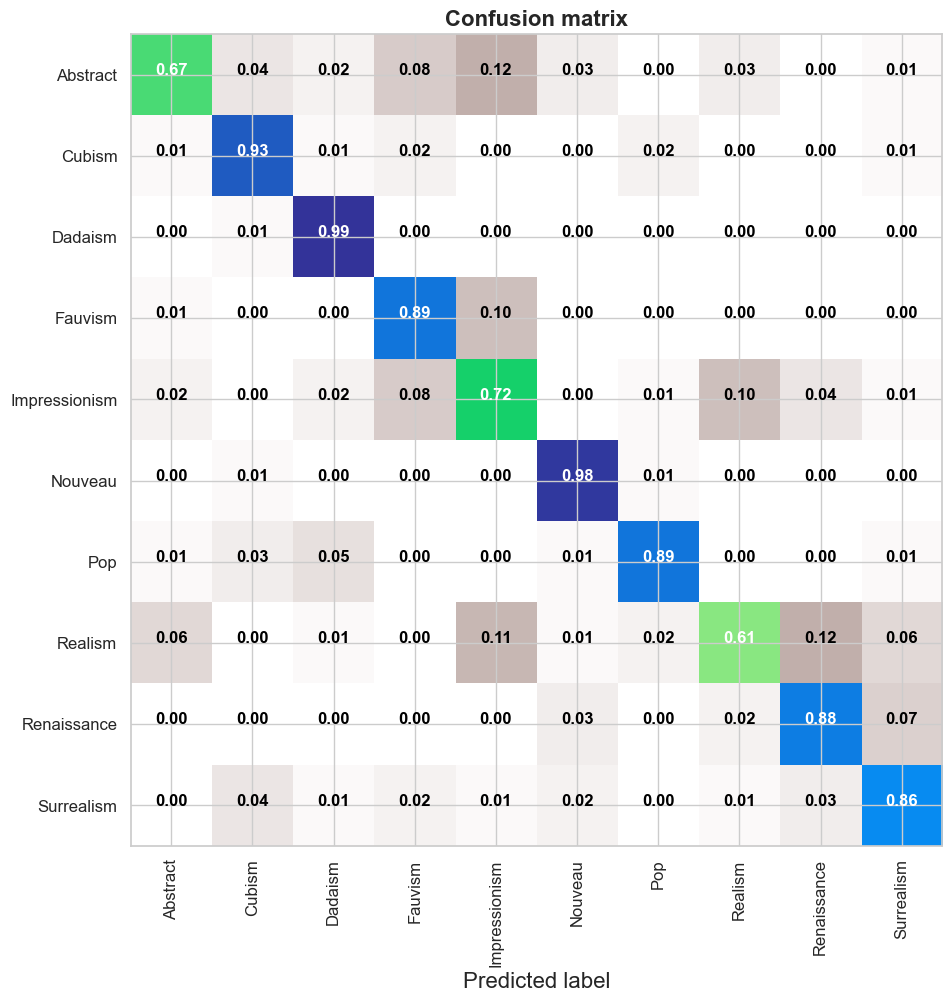

In [134]:
cnf_matrix = confusion_matrix(y_actual, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plt.xticks(rotation=90)
plot_confusion_matrix(cnf_matrix, classes=classes,
                      normalize=True, cmap='terrain_r')
# plt.savefig("confusion-matrix-val.png")

**PREDIKSI GAMBAR DI VALIDATION IMAGES**

In [123]:
class_indices = validation_dataset.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

In [124]:
def display_images(images, predictions, true_labels, title, class_names, num_images=9):
    plt.figure(figsize=(16, 16))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        color = 'green' if predictions[i] == true_labels[i] else 'red'
        plt.title("True: {}\nPred: {}".format(
            class_names[true_labels[i]], class_names[predictions[i]]), color=color)
        plt.axis("off")
    plt.suptitle(title, size=20)
    plt.show()

1/1 [==============================] - 0s 59ms/step


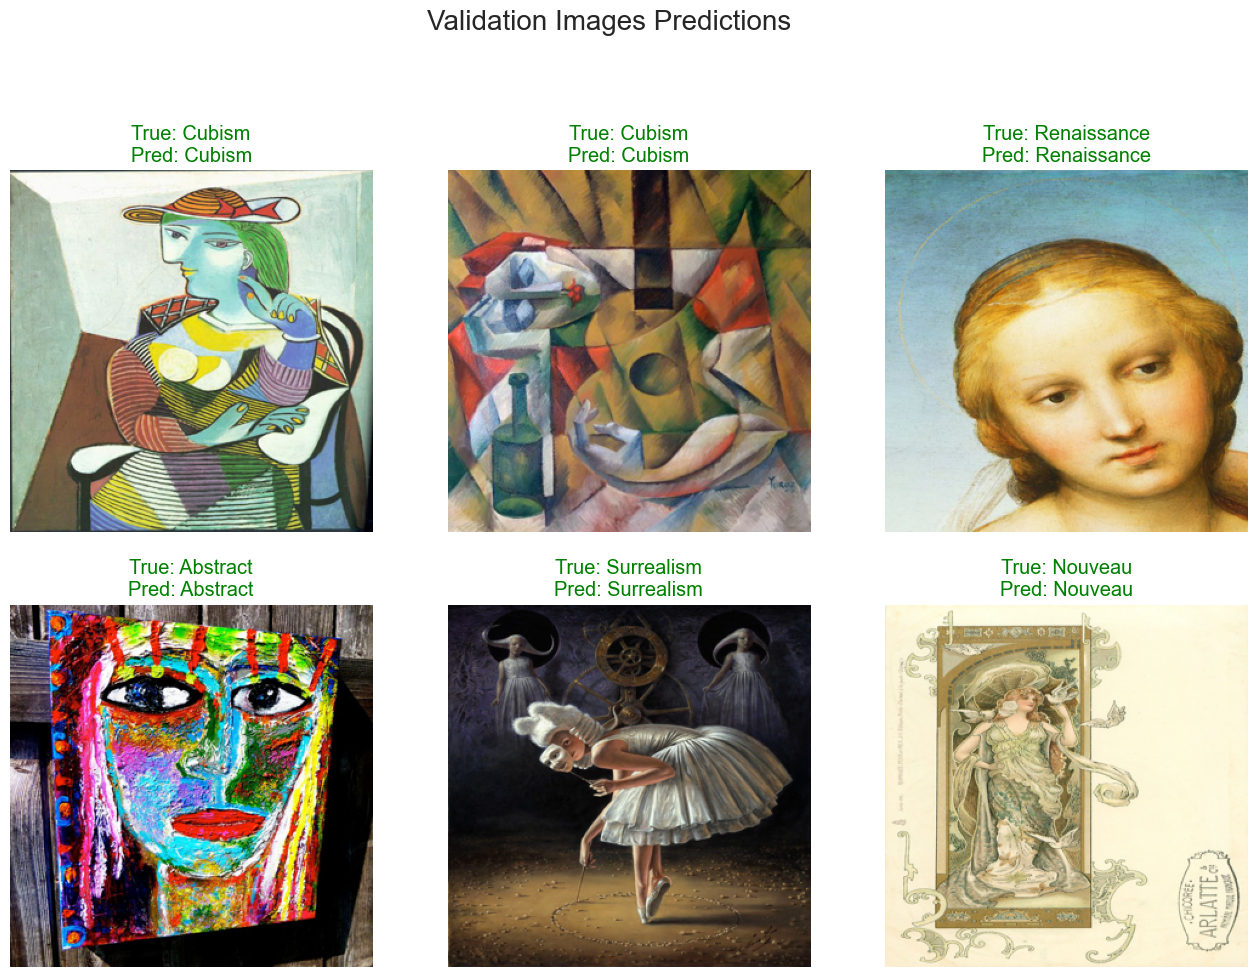

In [147]:
# Kumpulkan gambar, prediksi, dan label sebenarnya dari dataset validasi
def collect_validation_data(num_images):
    validation_images = []
    validation_labels = []

    # Reset iterator sebelum loop
    validation_dataset.reset()

    # Collect a manageable number of images and labels
    for i in range(num_images):
        images, labels = validation_dataset.next()
        validation_images.append(images[0])
        validation_labels.append(np.argmax(labels, axis=-1)[0])

    validation_images = np.array(validation_images)
    validation_labels = np.array(validation_labels)

    return validation_images, validation_labels


# Tentukan jumlah gambar yang ingin diplot
num_images = 6  # Ubah nilai ini sesuai kebutuhan

# Kumpulkan data validasi
validation_images, validation_labels = collect_validation_data(num_images)

# Prediksi
probabilities = model.predict(validation_images, batch_size=num_images)
predicted_classes = np.argmax(probabilities, axis=1)

# Tampilkan gambar dengan prediksi dan label sebenarnya
display_images(validation_images, predicted_classes,
               validation_labels, "Validation Images Predictions", idx_to_class, num_images)

In [126]:
# Load the model (replace 'your_model.h5' with your actual model file)
model = load_model('genre_classification_84.h5')

# Function to load class labels from the train_generator


def load_class_labels(generator):
    class_indices = generator.class_indices
    return {v: k for k, v in class_indices.items()}


# Assuming 'validation_dataset' is already defined and used to load the class labels
class_labels = load_class_labels(validation_dataset)

# Specify the directory containing images
image_directory = '.\images'

# Loop through the files in the directory
for filename in os.listdir(image_directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Predicting images
        path = os.path.join(image_directory, filename)
        img = load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        x = img_to_array(img)
        x /= 255.0
        x = np.expand_dims(x, axis=0)

        image_tensor = np.vstack([x])
        classes = model.predict(image_tensor)

        # Get the indices of the top 3 classes with the highest probabilities
        top_3_indices = np.argsort(classes[0])[-3:][::-1]

        print(f"Predictions for {filename}:")
        for i in top_3_indices:
            class_name = class_labels[i]
            probability = classes[0][i]
            print(f"Class: {class_name}, Probability: {probability:.2f}")

1/1 [==============================] - 1s 756ms/step
Predictions for abstract.png:
Class: Abstract, Probability: 0.98
Class: Fauvism, Probability: 0.02
Class: Impressionism, Probability: 0.00
1/1 [==============================] - 0s 26ms/step
Predictions for cubismm.jpg:
Class: Cubism, Probability: 0.85
Class: Pop, Probability: 0.14
Class: Abstract, Probability: 0.01
1/1 [==============================] - 0s 29ms/step
Predictions for dadaism.png:
Class: Fauvism, Probability: 0.57
Class: Cubism, Probability: 0.23
Class: Impressionism, Probability: 0.06
1/1 [==============================] - 0s 29ms/step
Predictions for dadaismm.png:
Class: Cubism, Probability: 0.39
Class: Impressionism, Probability: 0.21
Class: Surrealism, Probability: 0.18
1/1 [==============================] - 0s 27ms/step
Predictions for fauvismmm.png:
Class: Fauvism, Probability: 0.80
Class: Abstract, Probability: 0.14
Class: Impressionism, Probability: 0.04
1/1 [==============================] - 0s 27ms/step
Predi

**UNGGAH FILE DI GOOGLE COLAB**

In [127]:
# import numpy as np
# from google.colab import files
# from tensorflow.keras.utils import load_img, img_to_array

# # Fungsi untuk memuat label kelas dari train_generator


# def load_class_labels(generator):
#     class_indices = generator.class_indices
#     return {v: k for k, v in class_indices.items()}


# class_labels = load_class_labels(validation_dataset)

# # Mengunggah file
# uploaded = files.upload()

# for fn in uploaded.keys():

#     # predicting images
#     path = '/content/' + fn
#     img = load_img(path, target_size=(150, 150))
#     x = img_to_array(img)
#     x /= 255.0
#     x = np.expand_dims(x, axis=0)

#     image_tensor = np.vstack([x])
#     classes = model.predict(image_tensor)

#     # Mendapatkan indeks kelas dengan probabilitas tertinggi
#     top_3_indices = np.argsort(classes[0])[-3:][::-1]

#     print(f"Predictions for {fn}:")
#     for i in top_3_indices:
#         class_name = class_labels[i]
#         probability = classes[0][i]
#         print(f"Class: {class_name}, Probability: {probability:.2f}")

In [128]:
# Ekspor daftar paket yang aktif ke file requirements.txt
!pip freeze > requirements.txt

# Verifikasi bahwa file telah dibuat dengan benar
with open('requirements.txt', 'r') as file:
    print(file.read())


absl-py==1.4.0
array-record==0.4.0
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
Bottleneck @ file:///C:/b/abs_f05kqh7yvj/croot/bottleneck_1707864273291/work
cachetools==5.3.3
certifi==2024.2.2
charset-normalizer==3.3.2
click==8.1.7
colorama @ file:///C:/b/abs_a9ozq0l032/croot/colorama_1672387194846/work
comm @ file:///C:/b/abs_67a8058udb/croot/comm_1709322909844/work
contourpy @ file:///C:/b/abs_d5rpy288vc/croots/recipe/contourpy_1663827418189/work
cycler @ file:///tmp/build/80754af9/cycler_1637851556182/work
debugpy @ file:///C:/b/abs_c0y1fjipt2/croot/debugpy_1690906864587/work
decorator @ file:///opt/conda/conda-bld/decorator_1643638310831/work
dm-tree==0.1.8
etils==1.3.0
executing @ file:///opt/conda/conda-bld/executing_1646925071911/work
flatbuffers==24.3.25
fonttools @ file:///C:/b/abs_f47gnfqnx0/croot/fonttools_1713551644747/work
gast==0.4.0
google-auth==2.29.0
google-auth-